[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\kwiat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kwiat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kwiat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


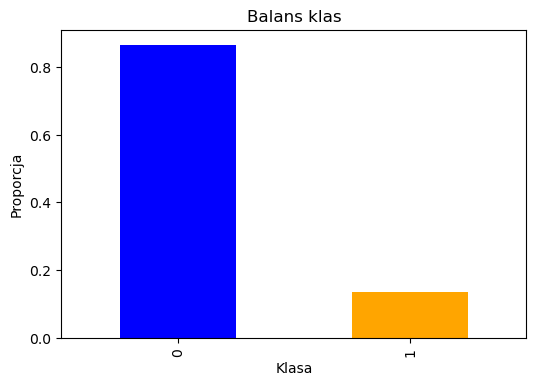

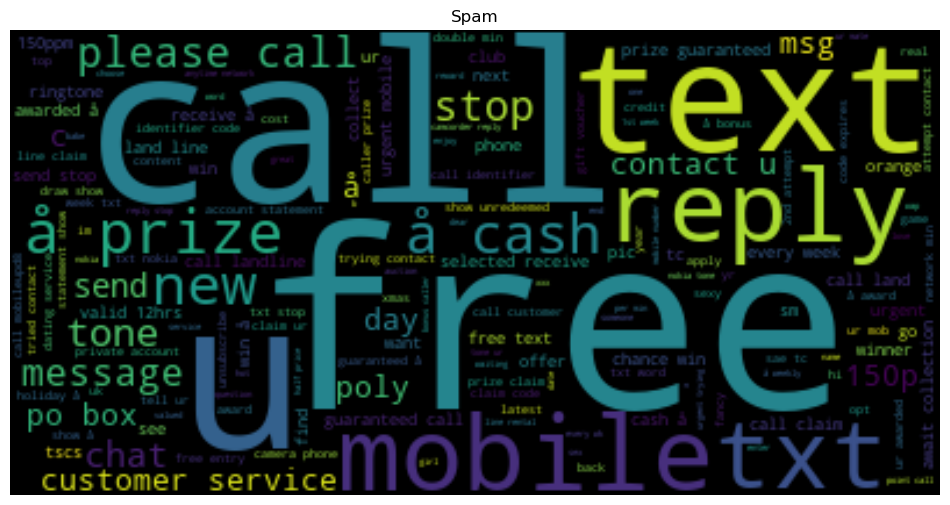

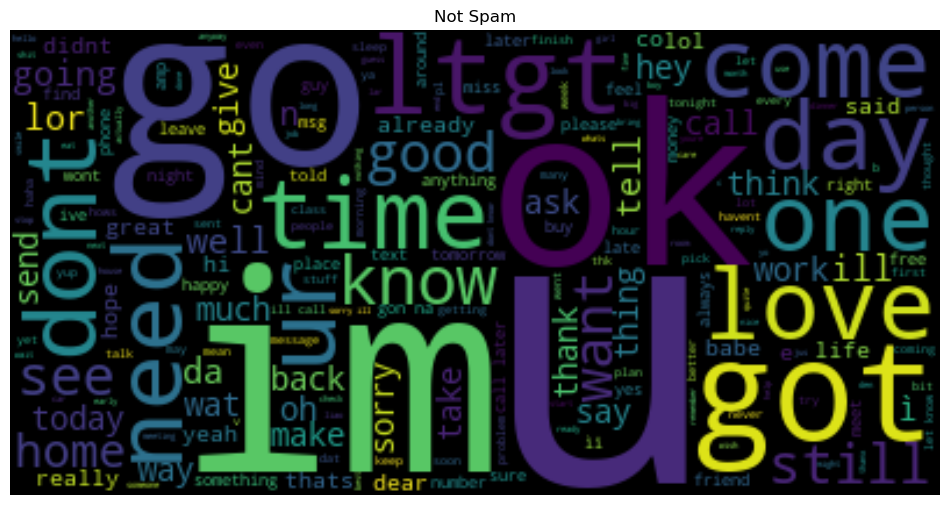

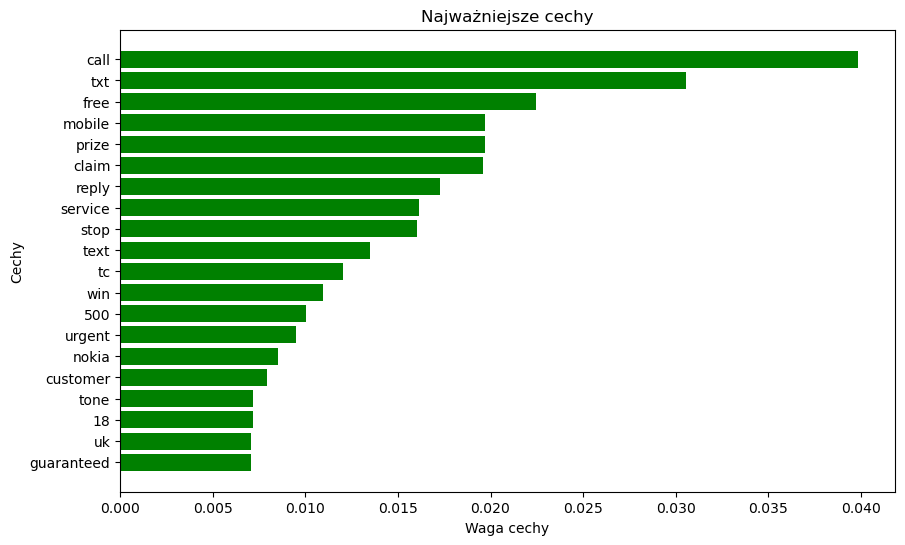

Najlepsze parametry: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 50}
Najlepszy wynik GridSearchCV: 0.9670163576848188
Dokładność na zbiorze testowym: 0.9730941704035875


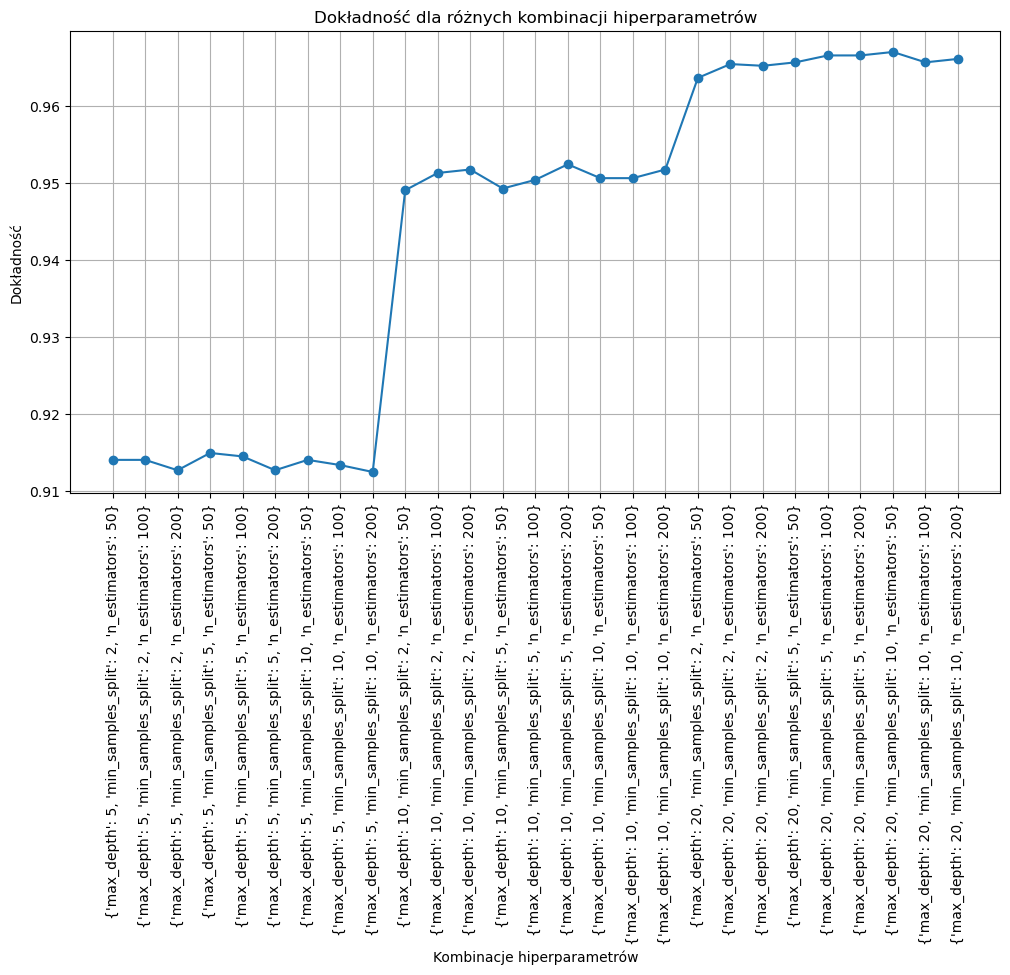

In [1]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import itertools
import numpy as np

# Upewnij się, że biblioteki NLTK są załadowane
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Wczytanie danych
spam_dataset = pd.read_csv('spam.csv', encoding="ISO-8859-1", usecols=[0, 1], names=['Spam', 'Text'], skiprows=1)
spam_dataset['Spam'] = spam_dataset['Spam'].map({'ham': 0, 'spam': 1}).astype('int32')

# Usunięcie znaków interpunkcyjnych
def remove_punctuation(text):
    return ''.join([char for char in text if char not in string.punctuation])
spam_dataset['Cleaned_Text'] = spam_dataset['Text'].apply(remove_punctuation)

# Tokenizacja i zmiana na małe litery
def tokenize(text):
    if pd.isna(text):
        return []
    return word_tokenize(text.lower())
spam_dataset['Tokenized_Text'] = spam_dataset['Cleaned_Text'].apply(tokenize)

# Usunięcie stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]
spam_dataset['WithoutStop_Text'] = spam_dataset['Tokenized_Text'].apply(remove_stopwords)

# Lematyzacja
lemmatizer = WordNetLemmatizer()
def lemmatizing(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]
spam_dataset['Lemmatized_Text'] = spam_dataset['WithoutStop_Text'].apply(lemmatizing)

# Wizualizacja rozkładu klas
plt.figure(figsize=(6, 4))
spam_dataset['Spam'].value_counts(normalize=True).plot(kind='bar', title='Balans klas', color=['blue', 'orange'])
plt.xlabel('Klasa')
plt.ylabel('Proporcja')
plt.show()

# Tworzenie chmur słów
def create_wordcloud(text, title):
    wordcloud = WordCloud().generate(' '.join(itertools.chain.from_iterable(text)))
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

spam_words = spam_dataset.loc[spam_dataset['Spam'] == 1, 'Lemmatized_Text']
ham_words = spam_dataset.loc[spam_dataset['Spam'] == 0, 'Lemmatized_Text']
create_wordcloud(spam_words, 'Spam')
create_wordcloud(ham_words, 'Not Spam')

# Wektoryzacja TF-IDF
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(spam_dataset['Lemmatized_Text'].apply(lambda x: ' '.join(x)))
y = spam_dataset['Spam']

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Trenowanie modelu Random Forest
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)

# Ważność cech
feature_importances = clf.feature_importances_
feature_names = tfidf.get_feature_names_out()
important_features = [(name, importance) for name, importance in zip(feature_names, feature_importances) if importance > 0.001]
important_features.sort(key=lambda x: x[1], reverse=True)

# Wizualizacja ważności cech
important_values = [importance for _, importance in important_features]
important_labels = [name for name, _ in important_features]
plt.figure(figsize=(10, 6))
plt.barh(important_labels[:20], important_values[:20], color='green')
plt.title('Najważniejsze cechy')
plt.xlabel('Waga cechy')
plt.ylabel('Cechy')
plt.gca().invert_yaxis()
plt.show()

# Filtrowanie ważnych cech
important_indices = [i for i, importance in enumerate(feature_importances) if importance > 0.001]
X_train_filtered = X_train[:, important_indices]
X_test_filtered = X_test[:, important_indices]

# Optymalizacja hiperparametrów z GridSearch
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=0), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_filtered, y_train)

# Najlepsze parametry i wynik
print("Najlepsze parametry:", grid_search.best_params_)
print("Najlepszy wynik GridSearchCV:", grid_search.best_score_)

# Ewaluacja na zbiorze testowym
best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test_filtered, y_test)
print("Dokładność na zbiorze testowym:", accuracy)

# Wizualizacja dokładności modelu
results = grid_search.cv_results_
param_combinations = [str(params) for params in results['params']]
mean_scores = results['mean_test_score']
plt.figure(figsize=(12, 6))
plt.plot(range(len(param_combinations)), mean_scores, marker='o')
plt.xticks(range(len(param_combinations)), param_combinations, rotation=90)
plt.title('Dokładność dla różnych kombinacji hiperparametrów')
plt.xlabel('Kombinacje hiperparametrów')
plt.ylabel('Dokładność')
plt.grid()
plt.show()
